In [1]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import osmnx as ox
import rioxarray
import pyproj
import shapely.geometry as sg
import networkx as nx
import momepy

In [2]:
# Test data
test_path = "C:/Users/ygrin/Documents/Studie - MSc ADS/Utrecht University/Block 4 - Thesis/TestData/"
test_results_path = "C:/Users/ygrin/Documents/Studie - MSc ADS/Utrecht University/Block 4 - Thesis/TestData/Results/"
single_point = gpd.read_file(test_path + "Test_single_home_location.gpkg")
multi_point = gpd.read_file(test_path + "Test_multiple_home_locations.gpkg")
#polygon = gpd.read_file(test_path + "TestArea.gpkg")
ndvi = rioxarray.open_rasterio(test_path + "NDVI_data_test.tif")
land_cover = rioxarray.open_rasterio(test_path + "Landcover_data_test.tif")
#network = gpd.read_file(test_path + "test_network.gpkg", layer='edges')
network = gpd.read_file(test_path + "test_network_shp.shp")
polygon = gpd.read_file(test_path + "test_polygon.gpkg")
canopy_single = gpd.read_file(test_path + "Canopy_single_home_500m.gpkg")

single_point_geographic = single_point.to_crs('epsg:4326')

# Greenness Accessibility -- Shortest Network Distance to Park

In [3]:
def calculate_shortest_distance(df_row=None, target_dist=None, network_graph=None, park_src=None, destination=None):   
    ### Step 1: Clip park boundaries to poi incl. buffer to minimize possible destination points
    park_src_buffer = park_src.clip(df_row['geometry'].buffer(target_dist))
    
    ### Step 2: Retrieve nearest network node for house location and calculate euclidian distance between these points
    # Euclidian distance will be added to network distance to minimize distance error
    nearest_node = ox.distance.nearest_nodes(network_graph, df_row['geometry'].x, df_row['geometry'].y)
    penalty_home = df_row['geometry'].distance(sg.Point(network_graph.nodes[nearest_node]['x'], network_graph.nodes[nearest_node]['y']))

    ### Step 3: Create fake entry points for parks by getting network nodes that are within 20m of park boundaries
    pos = {n: (network_graph.nodes[n]['x'], network_graph.nodes[n]['y']) for n in network_graph.nodes} # Create dictionary to extract geometries for nodes of interest
    
    # For each park, retrieve the network nodes which are within 20m of the park boundary and store in dictionary
    park_boundary_nodes = {}
    for park_index, boundary in park_src_buffer.boundary.items():
        park_id = park_src_buffer.loc[park_index, 'park_id']
        boundary_nodes = []
        for node in network_graph.nodes():
            node_pos = sg.Point(pos[node])
            if node_pos.distance(boundary) < 20:
                boundary_nodes.append(node)
        park_boundary_nodes[park_id] = boundary_nodes
    
    ### Step 4: Calculate the network distances between the house location's nearest node and the fake park entry points
    # Add penalty_home as defined before to network distance, as well as penalty_centroid in case user defined destination argument as "centroids"
    distances = {}
    for park_id, boundary_nodes in park_boundary_nodes.items():
        for node in boundary_nodes:
            try:
                path = nx.shortest_path(network_graph, nearest_node, node, weight='length')
                if destination == "centroids": 
                    # Calculate euclidian distance between the fake park entry points and the corresponding park's centroid to minimize distance error
                    penalty_centroid = park_src_buffer[park_src_buffer['park_id'] == park_id]['centroid'].iloc[0].distance(sg.Point(network_graph.nodes[node]['x'], network_graph.nodes[node]['y']))
                    distance = sum([network_graph.edges[path[i], path[i+1], 0]['length'] for i in range(len(path)-1)]) + penalty_home + penalty_centroid
                else:
                    distance = sum([network_graph.edges[path[i], path[i+1], 0]['length'] for i in range(len(path)-1)]) + penalty_home
                distances[node] = distance
            except:
                pass

    # Get the minimum distance (house location to park)
    if distances:
        min_distance = min(distances.values())
    else:
        min_distance = np.nan
    
    ### Step 5: Define result, if minimum distance smaller than/equal to target distance threshold --> Good
    if min_distance <= target_dist:
        outcome = "True"
    else:
        outcome = "False"
    
    return outcome

In [4]:
def get_shortest_distance_park(point_of_interest_file, crs_epsg=None, target_dist=300, park_vector_file=None, destination="centroids", 
                               network_file=None, network_type=None, output_dir=os.getcwd()):
    ### Step 1: Read and process user inputs, check conditions
    poi = gpd.read_file(point_of_interest_file)
    if all(poi['geometry'].geom_type == 'Point') or all(poi['geometry'].geom_type == 'Polygon'):
        geom_type = poi.iloc[0]['geometry'].geom_type
    else:
        raise ValueError("Please make sure all geometries are of 'Point' type or all geometries are of 'Polygon' type and re-run the function")

    if not poi.crs.is_projected:
        if crs_epsg is None:
            print("Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to CRS with EPSG:3395")
            epsg = 3395
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
        else:
            print(f"Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to EPSG:{crs_epsg} as specified")
            epsg = crs_epsg
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
    else:
        epsg = poi.crs.to_epsg()

    # In case of house polygons, transform to centroids
    if geom_type == "Polygon":
        print("Changing geometry type to Point by computing polygon centroids so that network distance can be retrieved...")
        poi['geometry'] = poi['geometry'].centroid
        print("Done \n")

    if "id" in poi.columns:
        if poi['id'].isnull().values.any():
            poi['id'] = poi['id'].fillna(pd.Series(range(1, len(poi) + 1))).astype(int)
    else:
        poi['id'] = pd.Series(range(1, len(poi) + 1)).astype(int)

    if not isinstance(target_dist, int) or (not target_dist > 0):
        raise TypeError("Please make sure that the target distance is set as a positive integer")
    
    if destination not in ["centroids", "entrance"]:
        raise TypeError("Please make sure that the destination argument is set to either 'centroids' or 'entrance'")

    ### Step 2: Obtain bounding box in which all points of interest are located, including 1000m buffer to account for edge effects
    poi_polygon = sg.box(*poi.total_bounds).buffer(1000)
    polygon_gdf_wgs = gpd.GeoDataFrame(geometry=[poi_polygon], crs=f"EPSG:{epsg}").to_crs("EPSG:4326") # Transform to 4326 for OSM
    wgs_polygon = polygon_gdf_wgs['geometry'].values[0] # Extract polygon in EPSG 4326

    ### Step 3: Read park polygons, retrieve from OSM if not provided by user 
    if park_vector_file is not None:
        park_src = gpd.read_file(park_vector_file)
        if not park_src.crs.to_epsg() == epsg:
            print("Adjusting CRS of Park file to match with Point of Interest CRS...")
            park_src.to_crs(f'EPSG:{epsg}', inplace=True)
            print("Done \n")
    else:
        print("Retrieving parks within total bounds of point(s) of interest, extended by a 1000m buffer to account for edge effects...")
        park_tags = {'leisure': 'park', 'boundary': 'national_park', 'landuse': 'recreation_ground'}
        park_src = ox.geometries_from_polygon(wgs_polygon, tags=park_tags)
        park_src.to_crs(f"EPSG:{epsg}", inplace=True)
        print("Done \n")
    
    if destination == "centroids":
        park_src['centroid'] = park_src['geometry'].centroid
    
    park_src['park_id'] = list(range(len(park_src)))

    ### Step 3: Read network, retrieve from OSM if not provided by user 
    if network_file is not None:
        if os.path.splitext(network_file)[1] not in [".gpkg", ".shp"]:
            raise ValueError("Please provide the network file in '.gpkg' or '.shp' format")
        elif network_file is not None and (os.path.splitext(network_file)[1] == ".gpkg"):
            network = gpd.read_file(network_file, layer='edges')
        elif network_file is not None and (os.path.splitext(network_file)[1] == ".shp"):
            network = gpd.read_file(network_file)

        if not network.crs.to_epsg() == epsg:
            print("Adjusting CRS of Network file to match with Point of Interest CRS...")
            network.to_crs(f'EPSG:{epsg}', inplace=True)
            print("Done \n")

        # Check if house locations are within network file provided
        bbox_network = network.unary_union.envelope
        if not all(geom.within(bbox_network) for geom in poi['geometry']):
            raise ValueError("Not all points of interest are within the network file provided, please make sure they are and re-run the function")

        # Convert network to graph object using momempy
        network_graph = momepy.gdf_to_nx(network)
    else:
        if network_type not in ["walk", "bike", "drive", "all"]:
            raise ValueError("Please make sure that the network_type argument is set to either 'walk', 'bike, 'drive' or 'all', and re-run the function")
            
        print("Retrieving infrastructure network within total bounds of point(s) of interest, extended by a 1000m buffer to account for edge effects...")
        network_graph = ox.graph_from_polygon(wgs_polygon, network_type=network_type)
        network_graph = ox.project_graph(network_graph, to_crs=f"EPSG:{epsg}")
        print("Done \n")
    
    ### Step 4: Perform calculations and write results to file
    print("Calculating shortest distances...")
    poi[f'park_within_{target_dist}m'] = poi.apply(lambda row: calculate_shortest_distance(df_row=row, target_dist=target_dist, network_graph=network_graph, park_src=park_src, destination=destination), axis=1)
    print("Done \n")
    
    print("Writing results to new geopackage file in specified directory...")
    input_filename, _ = os.path.splitext(os.path.basename(point_of_interest_file))
    poi.to_file(os.path.join(output_dir, f"{input_filename}_ShortDistPark_added.gpkg"), driver="GPKG")
    print("Done")

    return poi

In [5]:
shortest_dist = get_shortest_distance_park(point_of_interest_file=test_path + "Test_multiple_home_locations.gpkg", target_dist=500, 
                                           park_vector_file=None, network_file=None, network_type='all', output_dir=test_results_path,
                                           destination="centroids")

Retrieving parks within total bounds + 1000m of point(s) of interest...
Done 

Retrieving infrastructure network within total bounds + 1000m of point(s) of interest...
Done 

Calculating shortest distances...


c:\Users\ygrin\anaconda3\envs\spatial\lib\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
c:\Users\ygrin\anaconda3\envs\spatial\lib\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
c:\Users\ygrin\anaconda3\envs\spatial\lib\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use

Done 

Writing results to new geopackage file in specified directory...
Done


In [6]:
shortest_dist

,id,geometry,park_within_500m
0,1,POINT (388644.249 392861.634),True
1,2,POINT (385981.911 393805.494),False
2,3,POINT (388631.230 395322.181),False


# Testing

In [7]:
shortest_dist = get_shortest_distance_park(point_of_interest_file=test_path + "Test_single_home_location.gpkg", buffer_dist=500, 
                                           park_vector_file=None, network_file=test_path + "test_network.gpkg", network_type=None, 
                                           output_dir=test_results_path)

Retrieving parks within buffer distance for point(s) of interest...
Done 

Adjusting CRS of Network file to match with Point of Interest CRS...
Done 

Calculating shortest distances...


TypeError: Must pass list-like as `names`.

In [66]:
test_network = gpd.read_file(test_path + "test_network_shp.shp").to_crs("EPSG:27700")
test_network_graph = momepy.gdf_to_nx(test_network).to_directed()

In [33]:
epsg_transformer = pyproj.Transformer.from_crs("epsg:27700", "epsg:4326")
latlon = epsg_transformer.transform(single_point['geometry'].x, single_point['geometry'].y) # Transform point geometry into latlon for OSMnx
network_osmnx = ox.graph_from_point(latlon, dist=500, network_type='walk')

In [3]:
nodes = gpd.read_file(test_path + "test_network.gpkg", layer="nodes").set_index("osmid")
edges = gpd.read_file(test_path + "test_network.gpkg", layer="edges").set_index(["u", "v", "key"])
graph = ox.graph_from_gdfs(gdf_edges=edges, gdf_nodes=nodes)
epsg_transformer = pyproj.Transformer.from_crs("epsg:27700", "epsg:4326")
projected_graph = ox.project_graph(graph, to_crs="EPSG:27700")
latlon = epsg_transformer.transform(single_point['geometry'].x, single_point['geometry'].y)
park_tags = {'leisure': 'park', 'boundary': 'national_park', 'landuse': 'recreation_ground'}
park_src = ox.geometries_from_point(latlon, tags=park_tags, dist=500)
park_src.to_crs("EPSG:27700", inplace=True)

In [25]:
park_buffer = park_src.clip(single_point['geometry'].buffer(500))
nearest_node = ox.distance.nearest_nodes(projected_graph, single_point['geometry'].x, single_point['geometry'].y)
pos = {n: (projected_graph.nodes[n]['x'], projected_graph.nodes[n]['y']) for n in projected_graph.nodes}

boundary_nodes = []
for boundary in park_buffer.boundary:
    for node in projected_graph.nodes():
        node_pos = sg.Point(pos[node])
        if node_pos.distance(boundary) < 25:
            boundary_nodes.append(node)

distances = {}
for node in boundary_nodes:
    try:
        path = nx.shortest_path(projected_graph, nearest_node, node, weight='length') 
        distance = sum([projected_graph.edges[path[i], path[i+1], 0]['length'] for i in range(len(path)-1)])
        distances[node] = distance
    except:
        pass

c:\Users\ygrin\anaconda3\envs\spatial\lib\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [28]:
boundary_nodes

[31316277,
 7185123220,
 1673024358,
 1673024359,
 7185123217,
 31316284,
 1746811399,
 1746811400,
 1746811371,
 7185123210,
 1746811375,
 1673024362,
 1673024363,
 9322294644,
 9322294646,
 1673024373,
 1673029665,
 1746811369,
 1746811393,
 1746811380,
 1746811389,
 1746811395,
 8084457332]

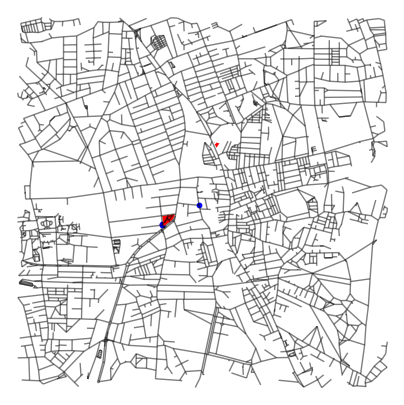

In [69]:
import matplotlib.pyplot as plt
# create a dictionary of node colors
node_ids = [1677080309,7185123220,31316277]
node_colors = {1677080309: 'blue', 7185123220: 'blue', 31316277: 'blue'}

# create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 5))

for node_id in projected_graph.nodes:
    # if the node is in the list of node IDs to highlight
    if node_id in node_ids:
        # get the node position and color
        node_pos = projected_graph.nodes[node_id]['x'], projected_graph.nodes[node_id]['y']
        node_color = node_colors[node_id]
        # plot the node with the corresponding color
        ax.scatter(*node_pos, s=10, c=node_color, edgecolors='blue')

# plot the geodataframe and the projected graph on the same axis
park_buffer.plot(ax=ax, color='red')
ox.plot_graph(projected_graph, ax=ax, node_size=0, edge_color='black', node_alpha=0.5, edge_alpha=0.5)

# show the plot
plt.show()